# Importing Libraries

In [101]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split,GridSearchCV

from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

import pickle

from operator import itemgetter

=======================================================================================================================

# Importing & Reading Data

In [2]:
df1 = pd.read_csv('Matches_Results.csv')

In [3]:
df1.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False


In [4]:
df2 = pd.read_csv('Fifa Ranking.csv')

In [5]:
df2.head()

,rank,country_full,country_abrv,total_points,previous_points,rank_change,confederation,rank_date
0,1,Germany,GER,57.0,0.0,0,UEFA,1992-12-31
1,96,Syria,SYR,11.0,0.0,0,AFC,1992-12-31
2,97,Burkina Faso,BFA,11.0,0.0,0,CAF,1992-12-31
3,99,Latvia,LVA,10.0,0.0,0,UEFA,1992-12-31
4,100,Burundi,BDI,10.0,0.0,0,CAF,1992-12-31


In [6]:
df1.shape

(44158, 9)

In [7]:
df1.columns

Index(['date', 'home_team', 'away_team', 'home_score', 'away_score',
       'tournament', 'city', 'country', 'neutral'],
      dtype='object')

In [8]:
df2.shape

(63916, 8)

In [9]:
df2.columns

Index(['rank', 'country_full', 'country_abrv', 'total_points',
       'previous_points', 'rank_change', 'confederation', 'rank_date'],
      dtype='object')

In [10]:
df1.isna().sum()

date          0
home_team     0
away_team     0
home_score    0
away_score    0
tournament    0
city          0
country       0
neutral       0
dtype: int64

In [11]:
df2.isna().sum()

rank               0
country_full       0
country_abrv       0
total_points       0
previous_points    0
rank_change        0
confederation      0
rank_date          0
dtype: int64

In [12]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44158 entries, 0 to 44157
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   date        44158 non-null  object
 1   home_team   44158 non-null  object
 2   away_team   44158 non-null  object
 3   home_score  44158 non-null  int64 
 4   away_score  44158 non-null  int64 
 5   tournament  44158 non-null  object
 6   city        44158 non-null  object
 7   country     44158 non-null  object
 8   neutral     44158 non-null  bool  
dtypes: bool(1), int64(2), object(6)
memory usage: 2.7+ MB


In [13]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63916 entries, 0 to 63915
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   rank             63916 non-null  int64  
 1   country_full     63916 non-null  object 
 2   country_abrv     63916 non-null  object 
 3   total_points     63916 non-null  float64
 4   previous_points  63916 non-null  float64
 5   rank_change      63916 non-null  int64  
 6   confederation    63916 non-null  object 
 7   rank_date        63916 non-null  object 
dtypes: float64(2), int64(2), object(4)
memory usage: 3.9+ MB


======================================================================================================================

# Data Wrangling

In [14]:
df1["date"] = pd.to_datetime(df1["date"])
df1 = df1[(df1["date"] >= "2018-8-1")].reset_index(drop=True)
df_Matches = df1

In [15]:
df2["rank_date"] = pd.to_datetime(df2["rank_date"]) 
df2 = df2[(df2["rank_date"] >= "2018-8-1")].reset_index(drop=True)
df2["country_full"] = df2["country_full"].str.replace("IR Iran", "Iran").str.replace("Korea Republic", "South Korea").str.replace("USA", "United States")
df2 = df2.set_index(['rank_date']).groupby(['country_full'], group_keys=False).resample('D').first().fillna(method='ffill').reset_index()

In [16]:
Main_DF = df_Matches.merge(df2[["country_full", "total_points", "previous_points", "rank", "rank_change", "rank_date"]], left_on=["date", "home_team"], right_on=["rank_date", "country_full"]).drop(["rank_date", "country_full"], axis=1)
Main_DF = Main_DF.merge(df2[["country_full", "total_points", "previous_points", "rank", "rank_change", "rank_date"]], left_on=["date", "away_team"], right_on=["rank_date", "country_full"], suffixes=("_home", "_away")).drop(["rank_date", "country_full"], axis=1)

=========================================================================================================================

# Last Look to our data 

In [17]:
Main_DF.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,total_points_home,previous_points_home,rank_home,rank_change_home,total_points_away,previous_points_away,rank_away,rank_change_away
0,2018-08-18,Andorra,United Arab Emirates,0,0,Friendly,Grödig,Austria,True,1120.0,1120.0,130.0,0.0,1312.0,1312.0,77.0,0.0
1,2018-08-18,Grenada,Jamaica,1,5,Friendly,St. George's,Grenada,False,980.0,980.0,168.0,0.0,1400.0,1400.0,54.0,0.0
2,2018-08-18,Guatemala,Cuba,1,0,Friendly,Quetzaltenango,Guatemala,False,1064.0,1064.0,146.0,0.0,940.0,940.0,181.0,0.0
3,2018-08-20,Barbados,Jamaica,2,2,Friendly,Bridgetown,Barbados,False,1005.0,1008.0,160.0,0.0,1400.0,1400.0,54.0,0.0
4,2018-08-26,Barbados,Cuba,0,0,Friendly,Bridgetown,Barbados,False,1005.0,1008.0,160.0,0.0,940.0,940.0,181.0,0.0


In [18]:
Main_DF.shape

(3336, 17)

============================================================================================================================

# Data Preprocessing

In [19]:
def result_finder(home, away):
    if home > away:
        return pd.Series([0, 3, 0])
    if home < away:
        return pd.Series([1, 0, 3])
    else:
        return pd.Series([2, 1, 1])

results = Main_DF.apply(lambda x: result_finder(x["home_score"], x["away_score"]), axis=1)

In [20]:
Main_DF[["result", "home_team_points", "away_team_points"]] = results

In [21]:
Main_DF["rank_dif"] = Main_DF["rank_home"] - Main_DF["rank_away"]
Main_DF["sg"] = Main_DF["home_score"] - Main_DF["away_score"]
Main_DF["points_home_by_rank"] = Main_DF["home_team_points"]/Main_DF["rank_away"]
Main_DF["points_away_by_rank"] = Main_DF["away_team_points"]/Main_DF["rank_home"]

In [22]:
home_team = Main_DF[["date", "home_team", "home_score", "away_score", "rank_home", "rank_away","rank_change_home", "total_points_home", "result", "rank_dif", "points_home_by_rank", "home_team_points"]]

away_team = Main_DF[["date", "away_team", "away_score", "home_score", "rank_away", "rank_home","rank_change_away", "total_points_away", "result", "rank_dif", "points_away_by_rank", "away_team_points"]]

In [23]:
home_team.columns = [h.replace("home_", "").replace("_home", "").replace("away_", "suf_").replace("_away", "_suf") for h in home_team.columns]

away_team.columns = [a.replace("away_", "").replace("_away", "").replace("home_", "suf_").replace("_home", "_suf") for a in away_team.columns]

In [24]:
team_stats = home_team.append(away_team)

In [25]:
team_stats

,date,team,score,suf_score,rank,rank_suf,rank_change,total_points,result,rank_dif,points_by_rank,team_points
0,2018-08-18,Andorra,0,0,130.0,77.0,0.0,1120.00,2,53.0,0.012987,1
1,2018-08-18,Grenada,1,5,168.0,54.0,0.0,980.00,1,114.0,0.000000,0
2,2018-08-18,Guatemala,1,0,146.0,181.0,0.0,1064.00,0,-35.0,0.016575,3
3,2018-08-20,Barbados,2,2,160.0,54.0,0.0,1005.00,2,106.0,0.018519,1
4,2018-08-26,Barbados,0,0,160.0,181.0,0.0,1005.00,2,-21.0,0.005525,1
...,...,...,...,...,...,...,...,...,...,...,...,...
3331,2022-09-27,Serbia,2,0,25.0,36.0,0.0,1549.53,1,11.0,0.083333,3
3332,2022-09-27,Slovenia,1,1,65.0,20.0,0.0,1372.48,2,-45.0,0.050000,1
3333,2022-09-27,Cyprus,1,5,108.0,106.0,1.0,1180.52,0,-2.0,0.000000,0
3334,2022-09-27,Northern Ireland,1,3,58.0,49.0,0.0,1399.10,0,-9.0,0.000000,0


In [26]:
stats_val = []

for index, row in team_stats.iterrows():
    team = row["team"]
    date = row["date"]
    past_games = team_stats.loc[(team_stats["team"] == team) & (team_stats["date"] < date)].sort_values(by=['date'], ascending=False)
    last5 = past_games.head(5)
    
    goals = past_games["score"].mean()
    goals_l5 = last5["score"].mean()
    
    goals_suf = past_games["suf_score"].mean()
    goals_suf_l5 = last5["suf_score"].mean()
    
    rank = past_games["rank_suf"].mean()
    rank_l5 = last5["rank_suf"].mean()
    
    if len(last5) > 0:
        points = past_games["total_points"].values[0] - past_games["total_points"].values[-1]#qtd de pontos ganhos
        points_l5 = last5["total_points"].values[0] - last5["total_points"].values[-1] 
    else:
        points = 0
        points_l5 = 0
        
    gp = past_games["team_points"].mean()
    gp_l5 = last5["team_points"].mean()
    
    gp_rank = past_games["points_by_rank"].mean()
    gp_rank_l5 = last5["points_by_rank"].mean()
    
    stats_val.append([goals, goals_l5, goals_suf, goals_suf_l5, rank, rank_l5, points, points_l5, gp, gp_l5, gp_rank, gp_rank_l5])

In [27]:
stats_val[-1]

[2.7857142857142856,
 1.8,
 1.8571428571428572,
 2.0,
 163.64285714285714,
 151.6,
 20.559999999999945,
 19.779999999999973,
 1.7142857142857142,
 2.0,
 0.010013100972005196,
 0.012386942407054688]

In [28]:
stats_mean = ["goals_mean", "goals_mean_l5", "goals_suf_mean", "goals_suf_mean_l5", "rank_mean", "rank_mean_l5", "points_mean", "points_mean_l5", "game_points_mean", "game_points_mean_l5", "game_points_rank_mean", "game_points_rank_mean_l5"]


In [29]:
stats_df = pd.DataFrame(stats_val, columns=stats_mean)

full_df = pd.concat([team_stats.reset_index(drop=True), stats_df], axis=1, ignore_index=False)

In [30]:
home_team_stats = full_df.iloc[:int(full_df.shape[0]/2),:]
away_team_stats = full_df.iloc[int(full_df.shape[0]/2):,:]

In [31]:
home_team_stats.columns[-12:]

Index(['goals_mean', 'goals_mean_l5', 'goals_suf_mean', 'goals_suf_mean_l5',
       'rank_mean', 'rank_mean_l5', 'points_mean', 'points_mean_l5',
       'game_points_mean', 'game_points_mean_l5', 'game_points_rank_mean',
       'game_points_rank_mean_l5'],
      dtype='object')

In [32]:
home_team_stats = home_team_stats[home_team_stats.columns[-12:]]
away_team_stats = away_team_stats[away_team_stats.columns[-12:]]

In [33]:
home_team_stats.columns = ['home_'+str(col) for col in home_team_stats.columns]
away_team_stats.columns = ['away_'+str(col) for col in away_team_stats.columns]

In [34]:
match_stats = pd.concat([home_team_stats, away_team_stats.reset_index(drop=True)], axis=1, ignore_index=False)
full_df = pd.concat([Main_DF, match_stats.reset_index(drop=True)], axis=1, ignore_index=False)

In [35]:
full_df.columns

Index(['date', 'home_team', 'away_team', 'home_score', 'away_score',
       'tournament', 'city', 'country', 'neutral', 'total_points_home',
       'previous_points_home', 'rank_home', 'rank_change_home',
       'total_points_away', 'previous_points_away', 'rank_away',
       'rank_change_away', 'result', 'home_team_points', 'away_team_points',
       'rank_dif', 'sg', 'points_home_by_rank', 'points_away_by_rank',
       'home_goals_mean', 'home_goals_mean_l5', 'home_goals_suf_mean',
       'home_goals_suf_mean_l5', 'home_rank_mean', 'home_rank_mean_l5',
       'home_points_mean', 'home_points_mean_l5', 'home_game_points_mean',
       'home_game_points_mean_l5', 'home_game_points_rank_mean',
       'home_game_points_rank_mean_l5', 'away_goals_mean',
       'away_goals_mean_l5', 'away_goals_suf_mean', 'away_goals_suf_mean_l5',
       'away_rank_mean', 'away_rank_mean_l5', 'away_points_mean',
       'away_points_mean_l5', 'away_game_points_mean',
       'away_game_points_mean_l5', 'away_

In [36]:
def find_friendly(x):
    if x == "Friendly":
        return 1
    else: return 0

full_df["is_friendly"] = full_df["tournament"].apply(lambda x: find_friendly(x)) 

In [37]:
full_df = pd.get_dummies(full_df, columns=["is_friendly"])

In [38]:
full_df.columns

Index(['date', 'home_team', 'away_team', 'home_score', 'away_score',
       'tournament', 'city', 'country', 'neutral', 'total_points_home',
       'previous_points_home', 'rank_home', 'rank_change_home',
       'total_points_away', 'previous_points_away', 'rank_away',
       'rank_change_away', 'result', 'home_team_points', 'away_team_points',
       'rank_dif', 'sg', 'points_home_by_rank', 'points_away_by_rank',
       'home_goals_mean', 'home_goals_mean_l5', 'home_goals_suf_mean',
       'home_goals_suf_mean_l5', 'home_rank_mean', 'home_rank_mean_l5',
       'home_points_mean', 'home_points_mean_l5', 'home_game_points_mean',
       'home_game_points_mean_l5', 'home_game_points_rank_mean',
       'home_game_points_rank_mean_l5', 'away_goals_mean',
       'away_goals_mean_l5', 'away_goals_suf_mean', 'away_goals_suf_mean_l5',
       'away_rank_mean', 'away_rank_mean_l5', 'away_points_mean',
       'away_points_mean_l5', 'away_game_points_mean',
       'away_game_points_mean_l5', 'away_

In [39]:
base_df = full_df[["date", "home_team", "away_team", "rank_home", "rank_away","home_score", "away_score","result", "rank_dif", "rank_change_home", "rank_change_away", 'home_goals_mean',
       'home_goals_mean_l5', 'home_goals_suf_mean', 'home_goals_suf_mean_l5',
       'home_rank_mean', 'home_rank_mean_l5', 'home_points_mean',
       'home_points_mean_l5', 'away_goals_mean', 'away_goals_mean_l5',
       'away_goals_suf_mean', 'away_goals_suf_mean_l5', 'away_rank_mean',
       'away_rank_mean_l5', 'away_points_mean', 'away_points_mean_l5','home_game_points_mean', 'home_game_points_mean_l5',
       'home_game_points_rank_mean', 'home_game_points_rank_mean_l5','away_game_points_mean',
       'away_game_points_mean_l5', 'away_game_points_rank_mean',
       'away_game_points_rank_mean_l5',
       'is_friendly_0', 'is_friendly_1']]

In [40]:
base_df_no_fg = base_df.dropna()

In [41]:
base_df_no_fg.result.value_counts()

0    1551
1     906
2     744
Name: result, dtype: int64

In [45]:
x = Main_DF.iloc[:, 3:]
y = Main_DF['target']

In [46]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size= 0.2, random_state=1)

============================================================================================================================

# Building & Training the Model

In [47]:
gb = GradientBoostingClassifier(random_state=5)

gb.fit(X_train, np.ravel(y_train))

GradientBoostingClassifier(random_state=5)

In [51]:
predictions = gb.predict(X_test)

============================================================================================================================

# Model Evaluation

c:\Users\omara\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
c:\Users\omara\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
c:\Users\omara\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
c:\Users\omara\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


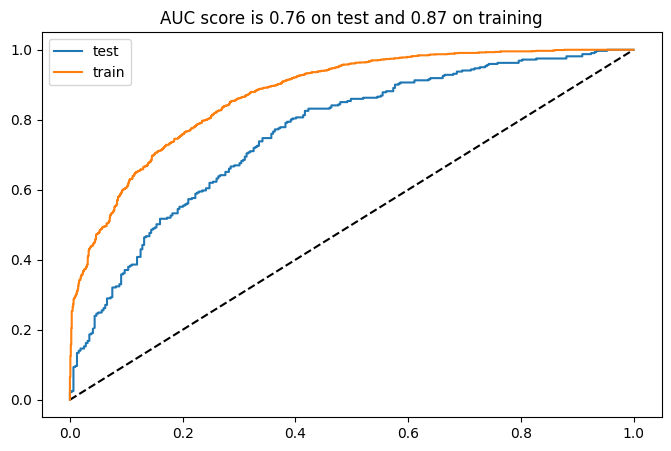

In [63]:
with plt.style.context('default'):    
    fpr, tpr, _ = roc_curve(y_test, gb.predict_proba(X_test.values)[:,1]) 
    plt.figure(figsize=(8,5))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label="test")

    fpr_train, tpr_train, _ = roc_curve(y_train, gb.predict_proba(X_train.values)[:,1])
    plt.plot(fpr_train, tpr_train, label="train")
    auc_test = roc_auc_score(y_test, gb.predict_proba(X_test.values)[:,1])
    auc_train = roc_auc_score(y_train, gb.predict_proba(X_train.values)[:,1])
    plt.legend()
    plt.title('AUC score is %.2f on test and %.2f on training'%(auc_test, auc_train))
    plt.show()

c:\Users\omara\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


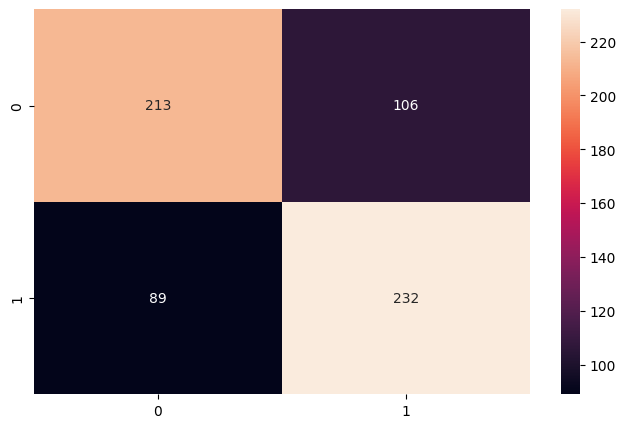

In [62]:
with plt.style.context('default'):    
    plt.figure(figsize=(8, 5))
    cm = confusion_matrix(y_test, gb.predict(X_test.values))
    sns.heatmap(cm, annot=True, fmt="d")

============================================================================================================================

# Optimization of the Model

In [65]:
parameters = {
            "learning_rate": [0.01, 0.1, 0.5],
            "min_samples_split": [5, 10],
            "min_samples_leaf": [3, 5],
            "max_depth":[3,5,10],
            "max_features":["sqrt"],
            "n_estimators":[100, 200]
}

In [66]:
gb_Model = GridSearchCV(gb,param_grid=parameters,cv = 3, n_jobs = -1,verbose=20)

In [67]:
gb_Model.fit(X_train,y_train)

Fitting 3 folds for each of 72 candidates, totalling 216 fits


GridSearchCV(cv=3, estimator=GradientBoostingClassifier(random_state=5),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.5],
                         'max_depth': [3, 5, 10], 'max_features': ['sqrt'],
                         'min_samples_leaf': [3, 5],
                         'min_samples_split': [5, 10],
                         'n_estimators': [100, 200]},
             verbose=20)

In [68]:
pd.DataFrame(gb_Model.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.385798,0.010998,0.007498,0.001866,0.01,3,sqrt,3,5,100,"{'learning_rate': 0.01, 'max_depth': 3, 'max_f...",0.714286,0.695193,0.709261,0.706247,0.008081,5
1,0.763993,0.011170,0.016214,0.006752,0.01,3,sqrt,3,5,200,"{'learning_rate': 0.01, 'max_depth': 3, 'max_f...",0.716628,0.703400,0.710434,0.710154,0.005404,1
2,0.384015,0.015018,0.009236,0.001294,0.01,3,sqrt,3,10,100,"{'learning_rate': 0.01, 'max_depth': 3, 'max_f...",0.714286,0.694021,0.709261,0.705856,0.008616,6
3,0.786623,0.019141,0.009703,0.001991,0.01,3,sqrt,3,10,200,"{'learning_rate': 0.01, 'max_depth': 3, 'max_f...",0.716628,0.701055,0.711606,0.709763,0.006490,2
4,0.375305,0.005841,0.007953,0.001480,0.01,3,sqrt,5,5,100,"{'learning_rate': 0.01, 'max_depth': 3, 'max_f...",0.713115,0.694021,0.709261,0.705466,0.008244,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,3.103452,0.279435,0.018049,0.002262,0.5,10,sqrt,3,10,200,"{'learning_rate': 0.5, 'max_depth': 10, 'max_f...",0.667447,0.676436,0.674091,0.672658,0.003807,56
68,1.596573,0.039409,0.014342,0.002118,0.5,10,sqrt,5,5,100,"{'learning_rate': 0.5, 'max_depth': 10, 'max_f...",0.681499,0.663540,0.678781,0.674607,0.007903,51
69,2.342106,0.040638,0.015482,0.000085,0.5,10,sqrt,5,5,200,"{'learning_rate': 0.5, 'max_depth': 10, 'max_f...",0.681499,0.670574,0.682298,0.678124,0.005348,47
70,1.668369,0.296682,0.013167,0.001066,0.5,10,sqrt,5,10,100,"{'learning_rate': 0.5, 'max_depth': 10, 'max_f...",0.681499,0.663540,0.678781,0.674607,0.007903,51


In [69]:
best_gb_model = gb_Model.best_estimator_

In [70]:
best_gb_model

GradientBoostingClassifier(learning_rate=0.01, max_features='sqrt',
                           min_samples_leaf=3, min_samples_split=5,
                           n_estimators=200, random_state=5)

============================================================================================================================

# Optimized Model

In [73]:
gb2 = GradientBoostingClassifier(learning_rate=0.01, max_features='sqrt',
                           min_samples_leaf=3, min_samples_split=5,
                           n_estimators=200, random_state=5)

gb2.fit(X_train, np.ravel(y_train))

GradientBoostingClassifier(learning_rate=0.01, max_features='sqrt',
                           min_samples_leaf=3, min_samples_split=5,
                           n_estimators=200, random_state=5)

In [74]:
Optimized_predictions = gb2.predict(X_test)

c:\Users\omara\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
c:\Users\omara\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
c:\Users\omara\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
c:\Users\omara\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


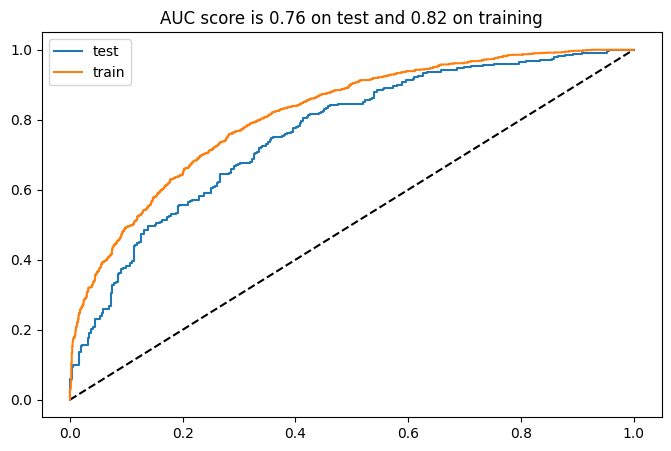

In [76]:
with plt.style.context('default'):    
    fpr, tpr, _ = roc_curve(y_test, gb2.predict_proba(X_test.values)[:,1]) 
    plt.figure(figsize=(8,5))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label="test")

    fpr_train, tpr_train, _ = roc_curve(y_train, gb2.predict_proba(X_train.values)[:,1])
    plt.plot(fpr_train, tpr_train, label="train")
    auc_test = roc_auc_score(y_test, gb2.predict_proba(X_test.values)[:,1])
    auc_train = roc_auc_score(y_train, gb2.predict_proba(X_train.values)[:,1])
    plt.legend()
    plt.title('AUC score is %.2f on test and %.2f on training'%(auc_test, auc_train))
    plt.show()

c:\Users\omara\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


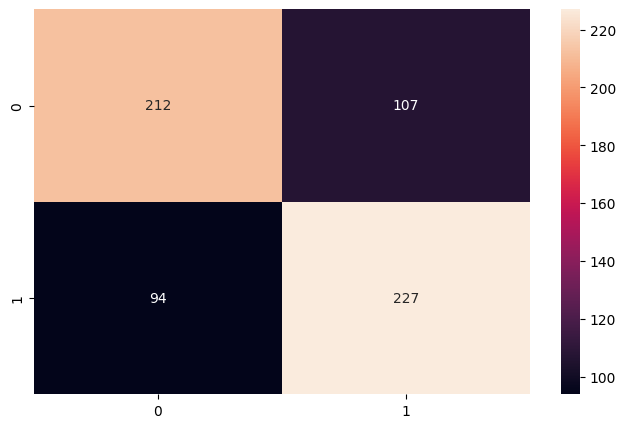

In [77]:
with plt.style.context('default'):    
    plt.figure(figsize=(8, 5))
    cm = confusion_matrix(y_test, gb2.predict(X_test.values))
    sns.heatmap(cm, annot=True, fmt="d")

============================================================================================================================

In [79]:
with open('gb_V2.pkl', 'wb') as f:
    pickle.dump(gb, f)

============================================================================================================================

# Starting World Cup Simulation

In [80]:
with open('PredictionModel.pkl' , 'rb') as f:
    gb = pickle.load(f)

In [108]:
tables = {'A': [['Qatar', 0, []],
  ['Ecuador', 0, []],
  ['Senegal', 0, []],
  ['Netherlands', 0, []]],
 'B': [['England', 0, []],
  ['Iran', 0, []],
  ['United States', 0, []],
  ['Wales', 0, []]],
 'C': [['Argentina', 0, []],
  ['Saudi Arabia', 0, []],
  ['Mexico', 0, []],
  ['Poland', 0, []]],
 'D': [['France', 0, []],
  ['Australia', 0, []],
  ['Denmark', 0, []],
  ['Tunisia', 0, []]],
 'E': [['Spain', 0, []],
  ['Costa Rica', 0, []],
  ['Germany', 0, []],
  ['Japan', 0, []]],
 'F': [['Belgium', 0, []],
  ['Canada', 0, []],
  ['Morocco', 0, []],
  ['Croatia', 0, []]],
 'G': [['Brazil', 0, []],
  ['Serbia', 0, []],
  ['Switzerland', 0, []],
  ['Cameroon', 0, []]],
 'H': [['Portugal', 0, []],
  ['Ghana', 0, []],
  ['Uruguay', 0, []],
  ['South Korea', 0, []]]}

In [94]:
matches = [('A', 'Qatar', 'Ecuador'),
 ('A', 'Netherlands', 'Senegal'),
 ('A', 'Qatar', 'Senegal'),
 ('A', 'Netherlands', 'Ecuador'),
 ('A', 'Ecuador', 'Senegal'),
 ('A', 'Netherlands', 'Qatar'),
 ('B', 'England', 'Iran'),
 ('B', 'United States', 'Wales'),
 ('B', 'Wales', 'Iran'),
 ('B', 'England', 'United States'),
 ('B', 'Wales', 'England'),
 ('B', 'Iran', 'United States'),
 ('C', 'Argentina', 'Saudi Arabia'),
 ('C', 'Mexico', 'Poland'),
 ('C', 'Poland', 'Saudi Arabia'),
 ('C', 'Argentina', 'Mexico'),
 ('C', 'Poland', 'Argentina'),
 ('C', 'Saudi Arabia', 'Mexico'),
 ('D', 'Denmark', 'Tunisia'),
 ('D', 'France', 'Australia'),
 ('D', 'Tunisia', 'Australia'),
 ('D', 'France', 'Denmark'),
 ('D', 'Australia', 'Denmark'),
 ('D', 'Tunisia', 'France'),
 ('E', 'Germany', 'Japan'),
 ('E', 'Spain', 'Costa Rica'),
 ('E', 'Japan', 'Costa Rica'),
 ('E', 'Spain', 'Germany'),
 ('E', 'Japan', 'Spain'),
 ('E', 'Costa Rica', 'Germany'),
 ('F', 'Morocco', 'Croatia'),
 ('F', 'Belgium', 'Canada'),
 ('F', 'Belgium', 'Morocco'),
 ('F', 'Croatia', 'Canada'),
 ('F', 'Croatia', 'Belgium'),
 ('F', 'Canada', 'Morocco'),
 ('G', 'Switzerland', 'Cameroon'),
 ('G', 'Brazil', 'Serbia'),
 ('G', 'Cameroon', 'Serbia'),
 ('G', 'Brazil', 'Switzerland'),
 ('G', 'Serbia', 'Switzerland'),
 ('G', 'Cameroon', 'Brazil'),
 ('H', 'Uruguay', 'South Korea'),
 ('H', 'Portugal', 'Ghana'),
 ('H', 'South Korea', 'Ghana'),
 ('H', 'Portugal', 'Uruguay'),
 ('H', 'Ghana', 'Uruguay'),
 ('H', 'South Korea', 'Portugal')]

In [96]:
matches[:5]

[('A', 'Qatar', 'Ecuador'),
 ('A', 'Netherlands', 'Senegal'),
 ('A', 'Qatar', 'Senegal'),
 ('A', 'Netherlands', 'Ecuador'),
 ('A', 'Ecuador', 'Senegal')]

In [98]:
base_df = pd.read_csv("team_stats.csv")

In [99]:
def find_stats(team_1):
#team_1 = "Qatar"
    past_games = base_df[(base_df["team"] == team_1)].sort_values("date")
    last5 = base_df[(base_df["team"] == team_1)].sort_values("date").tail(5)

    team_1_rank = past_games["rank"].values[-1]
    team_1_goals = past_games.score.mean()
    team_1_goals_l5 = last5.score.mean()
    team_1_goals_suf = past_games.suf_score.mean()
    team_1_goals_suf_l5 = last5.suf_score.mean()
    team_1_rank_suf = past_games.rank_suf.mean()
    team_1_rank_suf_l5 = last5.rank_suf.mean()
    team_1_gp_rank = past_games.points_by_rank.mean()
    team_1_gp_rank_l5 = last5.points_by_rank.mean()

    return [team_1_rank, team_1_goals, team_1_goals_l5, team_1_goals_suf, team_1_goals_suf_l5, team_1_rank_suf, team_1_rank_suf_l5, team_1_gp_rank, team_1_gp_rank_l5]

In [100]:
def find_features(team_1, team_2):
    rank_dif = team_1[0] - team_2[0]
    goals_dif = team_1[1] - team_2[1]
    goals_dif_l5 = team_1[2] - team_2[2]
    goals_suf_dif = team_1[3] - team_2[3]
    goals_suf_dif_l5 = team_1[4] - team_2[4]
    goals_per_ranking_dif = (team_1[1]/team_1[5]) - (team_2[1]/team_2[5])
    dif_rank_agst = team_1[5] - team_2[5]
    dif_rank_agst_l5 = team_1[6] - team_2[6]
    dif_gp_rank = team_1[7] - team_2[7]
    dif_gp_rank_l5 = team_1[8] - team_2[8]
    
    return [rank_dif, goals_dif, goals_dif_l5, goals_suf_dif, goals_suf_dif_l5, goals_per_ranking_dif, dif_rank_agst, dif_rank_agst_l5, dif_gp_rank, dif_gp_rank_l5, 1, 0]

In [109]:
tables

{'A': [['Qatar', 0, []],
  ['Ecuador', 0, []],
  ['Senegal', 0, []],
  ['Netherlands', 0, []]],
 'B': [['England', 0, []],
  ['Iran', 0, []],
  ['United States', 0, []],
  ['Wales', 0, []]],
 'C': [['Argentina', 0, []],
  ['Saudi Arabia', 0, []],
  ['Mexico', 0, []],
  ['Poland', 0, []]],
 'D': [['France', 0, []],
  ['Australia', 0, []],
  ['Denmark', 0, []],
  ['Tunisia', 0, []]],
 'E': [['Spain', 0, []],
  ['Costa Rica', 0, []],
  ['Germany', 0, []],
  ['Japan', 0, []]],
 'F': [['Belgium', 0, []],
  ['Canada', 0, []],
  ['Morocco', 0, []],
  ['Croatia', 0, []]],
 'G': [['Brazil', 0, []],
  ['Serbia', 0, []],
  ['Switzerland', 0, []],
  ['Cameroon', 0, []]],
 'H': [['Portugal', 0, []],
  ['Ghana', 0, []],
  ['Uruguay', 0, []],
  ['South Korea', 0, []]]}

In [110]:
advanced_group = []
last_group = ""
thresh = 0.05

for k in tables.keys():
    for t in tables[k]:
        t[1] = 0
        t[2] = []
        
for teams in matches:
    draw = False
    team_1 = find_stats(teams[1])
    team_2 = find_stats(teams[2])

    

    features_g1 = find_features(team_1, team_2)
    features_g2 = find_features(team_2, team_1)

    probs_g1 = gb.predict_proba([features_g1])
    probs_g2 = gb.predict_proba([features_g2])
    
    team_1_prob_g1 = probs_g1[0][0]
    team_1_prob_g2 = probs_g2[0][1]
    team_2_prob_g1 = probs_g1[0][1]
    team_2_prob_g2 = probs_g2[0][0]

    team_1_prob = (probs_g1[0][0] + probs_g2[0][1])/2
    team_2_prob = (probs_g2[0][0] + probs_g1[0][1])/2
    
    if ((team_1_prob_g1 > team_2_prob_g1) & (team_2_prob_g2 > team_1_prob_g2)) | ((team_1_prob_g1 < team_2_prob_g1) & (team_2_prob_g2 < team_1_prob_g2)):
        draw=True
        for i in tables[teams[0]]:
            if i[0] == teams[1] or i[0] == teams[2]:
                i[1] += 1
                
    elif team_1_prob > team_2_prob:
        winner = teams[1]
        winner_proba = team_1_prob
        for i in tables[teams[0]]:
            if i[0] == teams[1]:
                i[1] += 3
                
    elif team_2_prob > team_1_prob:  
        winner = teams[2]
        winner_proba = team_2_prob
        for i in tables[teams[0]]:
            if i[0] == teams[2]:
                i[1] += 3
    
    for i in tables[teams[0]]: #adding criterio de desempate (probs por jogo)
            if i[0] == teams[1]:
                i[2].append(team_1_prob)
            if i[0] == teams[2]:
                i[2].append(team_2_prob)

    if last_group != teams[0]:
        if last_group != "":
            print("\n")
            print("Group %s advanced: "%(last_group))
            
            for i in tables[last_group]: #adding crieterio de desempate
                i[2] = np.mean(i[2])
            
            final_points = tables[last_group]
            final_table = sorted(final_points, key=itemgetter(1, 2), reverse = True)
            advanced_group.append([final_table[0][0], final_table[1][0]])
            for i in final_table:
                print("%s -------- %d"%(i[0], i[1]))
        print("\n")
        print("-"*10+" Starting Analysis for Group %s "%(teams[0])+"-"*10)
        
        
    if draw == False:
        print("Group %s - %s vs. %s: Winner %s with %.2f probability"%(teams[0], teams[1], teams[2], winner, winner_proba))
    else:
        print("Group %s - %s vs. %s: Draw"%(teams[0], teams[1], teams[2]))
    last_group =  teams[0]

print("\n")
print("Group %s advanced: "%(last_group))

for i in tables[last_group]: #adding crieterio de desempate
    i[2] = np.mean(i[2])
            
final_points = tables[last_group]
final_table = sorted(final_points, key=itemgetter(1, 2), reverse = True)
advanced_group.append([final_table[0][0], final_table[1][0]])
for i in final_table:
    print("%s -------- %d"%(i[0], i[1]))

c:\Users\omara\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
c:\Users\omara\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
c:\Users\omara\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
c:\Users\omara\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
c:\Users\omara\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
c:\Users\omara\anaconda3\lib\site-packag



---------- Starting Analysis for Group A ----------
Group A - Qatar vs. Ecuador: Winner Ecuador with 0.62 probability
Group A - Netherlands vs. Senegal: Winner Netherlands with 0.62 probability
Group A - Qatar vs. Senegal: Winner Senegal with 0.60 probability
Group A - Netherlands vs. Ecuador: Winner Netherlands with 0.73 probability
Group A - Ecuador vs. Senegal: Draw
Group A - Netherlands vs. Qatar: Winner Netherlands with 0.78 probability


Group A advanced: 
Netherlands -------- 9
Senegal -------- 4
Ecuador -------- 4
Qatar -------- 0


---------- Starting Analysis for Group B ----------
Group B - England vs. Iran: Winner England with 0.62 probability
Group B - United States vs. Wales: Draw
Group B - Wales vs. Iran: Draw
Group B - England vs. United States: Winner England with 0.61 probability
Group B - Wales vs. England: Winner England with 0.64 probability
Group B - Iran vs. United States: Winner United States with 0.58 probability


Group B advanced: 
England -------- 9
United

c:\Users\omara\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
c:\Users\omara\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
c:\Users\omara\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
c:\Users\omara\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
c:\Users\omara\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
c:\Users\omara\anaconda3\lib\site-packag

Group D - France vs. Denmark: Draw
Group D - Australia vs. Denmark: Winner Denmark with 0.71 probability
Group D - Tunisia vs. France: Winner France with 0.69 probability


Group D advanced: 
France -------- 7
Denmark -------- 7
Tunisia -------- 1
Australia -------- 1


---------- Starting Analysis for Group E ----------
Group E - Germany vs. Japan: Winner Germany with 0.62 probability
Group E - Spain vs. Costa Rica: Winner Spain with 0.76 probability
Group E - Japan vs. Costa Rica: Winner Japan with 0.63 probability
Group E - Spain vs. Germany: Draw
Group E - Japan vs. Spain: Winner Spain with 0.67 probability
Group E - Costa Rica vs. Germany: Winner Germany with 0.65 probability


Group E advanced: 
Spain -------- 7
Germany -------- 7
Japan -------- 3
Costa Rica -------- 0


---------- Starting Analysis for Group F ----------
Group F - Morocco vs. Croatia: Winner Croatia with 0.58 probability
Group F - Belgium vs. Canada: Winner Belgium with 0.75 probability
Group F - Belgium vs. Mor

c:\Users\omara\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
c:\Users\omara\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
c:\Users\omara\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
c:\Users\omara\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
c:\Users\omara\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
c:\Users\omara\anaconda3\lib\site-packag

In [111]:
advanced = advanced_group

In [112]:
playoffs = {"Round of 16": [], "Quarter-Final": [], "Semi-Final": [], "Final": []}

In [113]:
for p in playoffs.keys():
    playoffs[p] = []

actual_round = ""
next_rounds = []

for p in playoffs.keys():
    if p == "Round of 16":
        control = []
        for a in range(0, len(advanced*2), 1):
            if a < len(advanced):
                if a % 2 == 0:
                    control.append((advanced*2)[a][0])
                else:
                    control.append((advanced*2)[a][1])
            else:
                if a % 2 == 0:
                    control.append((advanced*2)[a][1])
                else:
                    control.append((advanced*2)[a][0])

        playoffs[p] = [[control[c], control[c+1]] for c in range(0, len(control)-1, 1) if c%2 == 0]
        
        for i in range(0, len(playoffs[p]), 1):
            game = playoffs[p][i]
            
            home = game[0]
            away = game[1]
            team_1 = find_stats(home)
            team_2 = find_stats(away)

            features_g1 = find_features(team_1, team_2)
            features_g2 = find_features(team_2, team_1)
            
            probs_g1 = gb.predict_proba([features_g1])
            probs_g2 = gb.predict_proba([features_g2])
            
            team_1_prob = (probs_g1[0][0] + probs_g2[0][1])/2
            team_2_prob = (probs_g2[0][0] + probs_g1[0][1])/2
            
            if actual_round != p:
                print("-"*10)
                print("Starting simulation of %s"%(p))
                print("-"*10)
                print("\n")
            
            if team_1_prob < team_2_prob:
                print("%s vs. %s: %s advances with prob %.2f"%(home, away, away, team_2_prob))
                next_rounds.append(away)
            else:
                print("%s vs. %s: %s advances with prob %.2f"%(home, away, home, team_1_prob))
                next_rounds.append(home)
            
            game.append([team_1_prob, team_2_prob])
            playoffs[p][i] = game
            actual_round = p
        
    else:
        playoffs[p] = [[next_rounds[c], next_rounds[c+1]] for c in range(0, len(next_rounds)-1, 1) if c%2 == 0]
        next_rounds = []
        for i in range(0, len(playoffs[p])):
            game = playoffs[p][i]
            home = game[0]
            away = game[1]
            team_1 = find_stats(home)
            team_2 = find_stats(away)
            
            features_g1 = find_features(team_1, team_2)
            features_g2 = find_features(team_2, team_1)
            
            probs_g1 = gb.predict_proba([features_g1])
            probs_g2 = gb.predict_proba([features_g2])
            
            team_1_prob = (probs_g1[0][0] + probs_g2[0][1])/2
            team_2_prob = (probs_g2[0][0] + probs_g1[0][1])/2
            
            if actual_round != p:
                print("-"*10)
                print("Starting simulation of %s"%(p))
                print("-"*10)
                print("\n")
            
            if team_1_prob < team_2_prob:
                print("%s vs. %s: %s advances with prob %.2f"%(home, away, away, team_2_prob))
                next_rounds.append(away)
            else:
                print("%s vs. %s: %s advances with prob %.2f"%(home, away, home, team_1_prob))
                next_rounds.append(home)
            game.append([team_1_prob, team_2_prob])
            playoffs[p][i] = game
            actual_round = p
            

----------
Starting simulation of Round of 16
----------


Netherlands vs. United States: Netherlands advances with prob 0.54
Argentina vs. Denmark: Argentina advances with prob 0.59
Spain vs. Croatia: Spain advances with prob 0.61
Brazil vs. Uruguay: Brazil advances with prob 0.64
Senegal vs. England: England advances with prob 0.64
Poland vs. France: France advances with prob 0.67
Germany vs. Belgium: Belgium advances with prob 0.53
Switzerland vs. Portugal: Portugal advances with prob 0.57
----------
Starting simulation of Quarter-Final
----------


Netherlands vs. Argentina: Netherlands advances with prob 0.51
Spain vs. Brazil: Brazil advances with prob 0.54
England vs. France: England advances with prob 0.51
Belgium vs. Portugal: Portugal advances with prob 0.52
----------
Starting simulation of Semi-Final
----------


Netherlands vs. Brazil: Brazil advances with prob 0.55
England vs. Portugal: England advances with prob 0.51
----------
Starting simulation of Final
----------


Br

c:\Users\omara\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
c:\Users\omara\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
c:\Users\omara\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
c:\Users\omara\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
c:\Users\omara\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
c:\Users\omara\anaconda3\lib\site-packag

============================================================================================================================

# The Winner is Brazil!!!!!!